In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [3]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
data = pd.read_csv(next(iter(uploaded)))
data.head()

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset.csv


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Base models
lr = LogisticRegression(max_iter=1000)
svm = SVC(kernel='rbf', probability=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

lr.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [8]:
# Voting Ensemble
voting = VotingClassifier(
    estimators=[
        ('LogReg', lr),
        ('SVM', svm),
        ('RF', rf)
    ],
    voting='soft'
)
voting.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('LogReg', LogisticRegression(max_iter=1000)),
                             ('SVM', SVC(probability=True)),
                             ('RF', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [9]:
# Predictions
models = {
    "Logistic Regression": lr.predict(X_test_scaled),
    "SVM": svm.predict(X_test_scaled),
    "Random Forest": rf.predict(X_test),
    "Gradient Boosting": gb.predict(X_test),
    "Voting Ensemble": voting.predict(X_test_scaled)
}


In [10]:

# Metrics
results = []
for name, preds in models.items():
    results.append([
        name,
        accuracy_score(y_test, preds),
        precision_score(y_test, preds),
        recall_score(y_test, preds),
        f1_score(y_test, preds)
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

print("=== Ensemble & Base Model Comparison ===")
print(results_df)

=== Ensemble & Base Model Comparison ===
                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression  0.800000   0.933333    0.56  0.700000
1                  SVM  0.750000   0.857143    0.48  0.615385
2        Random Forest  0.750000   0.857143    0.48  0.615385
3    Gradient Boosting  0.716667   0.750000    0.48  0.585366
4      Voting Ensemble  0.766667   0.923077    0.48  0.631579


In [11]:
# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
                     Feature  Importance
11                      time    0.375186
7           serum_creatinine    0.155334
4          ejection_fraction    0.112341
2   creatinine_phosphokinase    0.082606
0                        age    0.078224
6                  platelets    0.075128
8               serum_sodium    0.064939
1                    anaemia    0.015220
10                   smoking    0.011217
5        high_blood_pressure    0.010240



Confusion Matrix (Voting Ensemble):
[[34  1]
 [13 12]]


<Figure size 600x500 with 0 Axes>

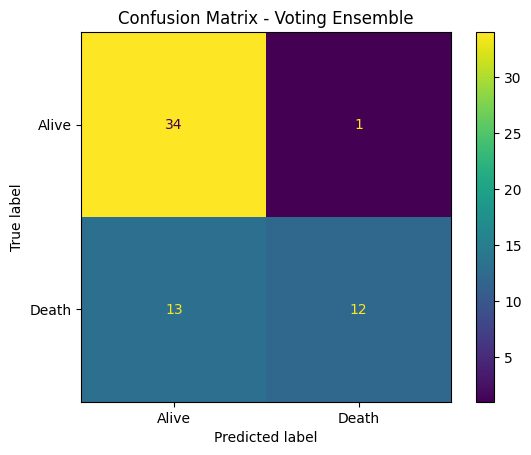

In [12]:
# Confusion Matrix for Ensemble
print("\nConfusion Matrix (Voting Ensemble):")
print(confusion_matrix(y_test, voting.predict(X_test_scaled)))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_ensemble = voting.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_ensemble)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Alive", "Death"]
)
plt.figure(figsize=(6, 5))
disp.plot()
plt.title("Confusion Matrix - Voting Ensemble")
plt.show()

In [13]:
print(data['DEATH_EVENT'].value_counts())
print("\nPercentage:")
print(data['DEATH_EVENT'].value_counts(normalize=True)*100)


DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

Percentage:
DEATH_EVENT
0    67.892977
1    32.107023
Name: proportion, dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


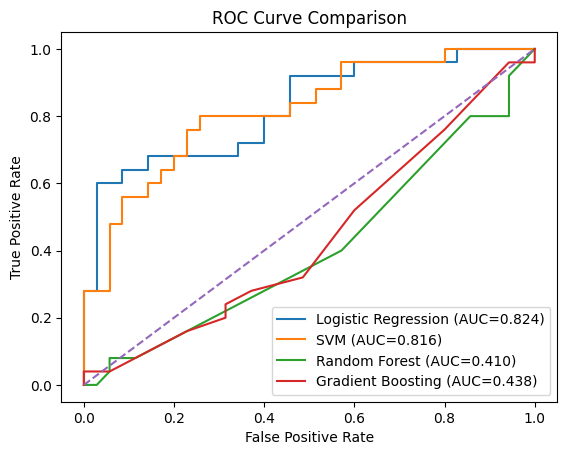

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": lr,
    "SVM": svm,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

plt.figure()

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        from sklearn.calibration import CalibratedClassifierCV
        cal = CalibratedClassifierCV(model)
        cal.fit(X_train_scaled, y_train)
        probs = cal.predict_proba(X_test_scaled)[:,1]

    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


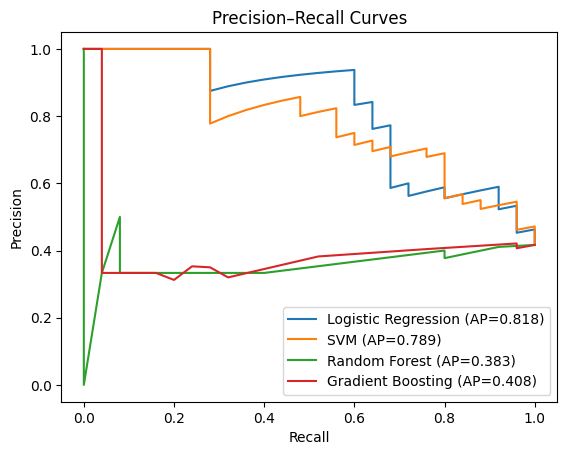

In [15]:
#precision call curve

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure()

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        from sklearn.calibration import CalibratedClassifierCV
        cal = CalibratedClassifierCV(model)
        cal.fit(X_train_scaled, y_train)
        probs = cal.predict_proba(X_test_scaled)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()


In [16]:
import numpy as np

print("\n=== Random Forest Importance ===")
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))

print("\n=== Gradient Boosting Importance ===")
gb_imp = pd.Series(gb.feature_importances_, index=X.columns)
print(gb_imp.sort_values(ascending=False).head(10))

print("\n=== Logistic Regression Coefficients ===")
lr_coef = pd.Series(np.abs(lr.coef_[0]), index=X.columns)
print(lr_coef.sort_values(ascending=False).head(10))



=== Random Forest Importance ===
time                        0.375186
serum_creatinine            0.155334
ejection_fraction           0.112341
creatinine_phosphokinase    0.082606
age                         0.078224
platelets                   0.075128
serum_sodium                0.064939
anaemia                     0.015220
smoking                     0.011217
high_blood_pressure         0.010240
dtype: float64

=== Gradient Boosting Importance ===
time                        0.568098
serum_creatinine            0.134073
ejection_fraction           0.080289
creatinine_phosphokinase    0.073946
platelets                   0.056224
serum_sodium                0.041807
age                         0.033832
sex                         0.007579
smoking                     0.002239
anaemia                     0.001347
dtype: float64

=== Logistic Regression Coefficients ===
time                        1.651880
ejection_fraction           0.876051
serum_creatinine            0.701778
age  

In [17]:
#Threshold tuning

import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = lr.predict_proba(X_test_scaled)[:,1]
thresholds = np.arange(0.1, 0.9, 0.05)

print("Thresh  Recall   F1")
for t in thresholds:
    preds = (probs >= t).astype(int)
    print(f"{t:.2f}   {recall_score(y_test,preds):.3f}   {f1_score(y_test,preds):.3f}")


Thresh  Recall   F1
0.10   0.920   0.719
0.15   0.680   0.642
0.20   0.680   0.654
0.25   0.680   0.694
0.30   0.640   0.696
0.35   0.640   0.727
0.40   0.600   0.732
0.45   0.600   0.732
0.50   0.560   0.700
0.55   0.480   0.632
0.60   0.320   0.471
0.65   0.280   0.424
0.70   0.280   0.424
0.75   0.280   0.438
0.80   0.280   0.438
0.85   0.280   0.438


In [18]:
import joblib
joblib.dump(rf, "heart_failure_predictor.joblib")

['heart_failure_predictor.joblib']